In [2]:
import numpy as np

In [3]:
# text processing libraries
import re
import string

# LSTM  
from numpy import array
import matplotlib.pyplot as plt
from pandas import read_csv
import math

import pandas as pd

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 200

num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
act = 'relu'

In [4]:
from google.colab import files
data_to_load = files.upload()

Saving Train_TP2_Datos_2020-2C.csv to Train_TP2_Datos_2020-2C.csv
Saving Test_TP2_Datos_2020-2C.csv to Test_TP2_Datos_2020-2C.csv


In [463]:
import io
test_df = pd.read_csv(io.BytesIO(data_to_load['Test_TP2_Datos_2020-2C.csv']))
train_df = pd.read_csv(io.BytesIO(data_to_load['Train_TP2_Datos_2020-2C.csv']))

In [464]:
train_df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,USD,0.58817,5/1/2016,6/30/2016,2016 - 5,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,USD,0.59948,1/18/2016,1/20/2016,2016 - 1,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,12/8/2015,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.48,USD,0.48000,1/25/2016,1/25/2016,2016 - 1,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,3/31/2018,2018 - 2,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,2/28/2018,2018 - 2,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


In [465]:
test_df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
0,6140,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_171,Product_Name_332,EUR,0.325,USD,0.36761,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None
1,6146,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None
2,6151,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_140,Product_Name_241,EUR,0.275,USD,0.31105,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None
3,6118,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_171,Product_Name_328,EUR,0.325,USD,0.36761,6/1/2019,6/28/2019,2019 - 6,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None
4,6124,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,6/1/2019,6/29/2019,2019 - 6,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None


In [466]:
#Y convierto las victorias en 1 y derrotas en 0
train_df = train_df[(train_df.Stage == 'Closed Won') | (train_df.Stage == 'Closed Lost')]
train_df['Stage'] = train_df['Stage'].transform(func=lambda x : 1 if x=='Closed Won' else 0)


In [467]:

train_df['TRF'] = train_df['TRF'].astype(int)
test_df['TRF'] = test_df['TRF'].astype(int)

In [468]:
train = train_df.drop_duplicates('Opportunity_ID')
test = test_df.drop_duplicates('Opportunity_ID')

In [469]:
train

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.5200,USD,0.58817,5/1/2016,6/30/2016,2016 - 5,Q2,2016,NaT,10,EUR,5272800.00,EUR,5272800.0,0,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.5300,USD,0.59948,1/18/2016,1/20/2016,2016 - 1,Q1,2016,NaT,0,EUR,48230.00,EUR,48230.0,1,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,12/8/2015,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.4800,USD,0.48000,1/25/2016,1/25/2016,2016 - 1,Q1,2016,NaT,0,USD,83865.60,USD,83865.6,1,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.5300,USD,0.53000,2/1/2018,3/31/2018,2018 - 2,Q1,2018,NaT,14,USD,7421881.50,USD,7421881.5,0,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.5300,USD,0.53000,2/1/2018,2/28/2018,2018 - 2,Q1,2018,NaT,25,USD,13357192.50,USD,13357192.5,0,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16939,18324,EMEA,Norway,1,1,0,0,0,Bureaucratic_Code_4,7/27/2013,Source_9,Germany,Account_Name_533,Opportunity_Name_7202,12799,224,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/4/2015,None,None,None,None,None,None,NaT,4/3/2016,4/1/2016,Person_Name_13,Product_Family_77,Product_Name_96,EUR,0.5150,USD,0.58251,4/1/2016,4/21/2016,2016 - 4,Q2,2016,NaT,1,EUR,401700.00,EUR,401700.0,1,Prod_Category_A_None
16940,20827,Americas,NE America,1,0,0,0,0,Bureaucratic_Code_5,6/16/2014,None,Germany,Account_Name_404,Opportunity_Name_11979,12800,None,Person_Name_13,Person_Name_13,Account

In [470]:
train = train[['Opportunity_ID', 'Territory', 'Stage', 'TRF']]

In [471]:
train = train.mask(train.eq('None')).dropna()

In [472]:
train.head()

,Opportunity_ID,Territory,Stage,TRF
2,2,NW America,1,0
3,3,NW America,0,14
4,4,NW America,0,25
5,5,NW America,0,28
6,6,NW America,0,7


In [473]:
# territory = train[['Territory']]
# territory

In [474]:
# # turn train into dict
# X_dict = territory.to_dict(orient='records') # turn each row as key-value pairs
# # show X_dict
# X_dict

In [475]:
# # DictVectorizer
# from sklearn.feature_extraction import DictVectorizer
# # instantiate a Dictvectorizer object for X
# dv_X = DictVectorizer(sparse=False) 
# # sparse = False makes the output is not a sparse matrix

In [476]:
# # apply dv_X on X_dict
# X_encoded = dv_X.fit_transform(X_dict)
# # show X_encoded
# X_encoded

In [477]:
# # vocabulary
# vocab = dv_X.vocabulary_
# # show vocab
# vocab

In [478]:
print(X_encoded.shape)


(7940, 74)


In [479]:
maxlen = 100


X_train = pad_sequences(X_encoded, padding='post', maxlen=maxlen)
X_train.shape

(7940, 100)

In [488]:
X = train['Territory']
le = LabelEncoder()
X = le.fit_transform(X)
X1 = X.reshape(-1,1)
X1.shape

(7940, 1)

In [490]:
X2 = train['TRF']
le = LabelEncoder()
X2 = le.fit_transform(X2)
X2 = X2.reshape(-1,1)
X2.shape
X2

array([[ 0],
       [14],
       [25],
       ...,
       [ 0],
       [ 4],
       [39]])

In [504]:
from sklearn.preprocessing import LabelEncoder
Y_train =train['Stage']


In [ ]:

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(Y_train)))

In [491]:
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

In [497]:
from keras.models import Sequential
from keras.layers import Dropout, Reshape, Bidirectional

from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.layers.merge import concatenate

In [520]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)

lstm_layer = LSTM(128, dropout=0.25, recurrent_dropout=0.2)

embedding = Embedding(200, 200, input_length=1)

sequence_1_input = Input(shape=(1,), dtype='int32')
embedded_sequences_1 = embedding(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_1_output = Dense(64, activation=act)(x1)
sequence_1_output = Dropout(rate_drop_dense)(sequence_1_output)

x = Model(inputs=sequence_1_input, outputs=sequence_1_output)


sequence_2_input = Input(shape=(1, ), dtype='int32')
embedded_sequences_2 = embedding(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

sequence_2_output = Dense(64, activation=act)(y1)
sequence_2_output = Dropout(rate_drop_dense)(sequence_2_output)

y = Model(inputs=sequence_2_input, outputs=sequence_2_output)

merged = concatenate([x.output, y.output])

merged = Dropout(rate_drop_dense)(merged)

merged = Dense(64, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)

merged = Dense(32, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)

merged = Dense(16, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)

preds = Dense(1, activation='sigmoid')(merged)


model = Model(inputs=[sequence_1_input, sequence_2_input], \
        outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer=opt,
        metrics=['acc'])

In [521]:
print(model.summary())

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_65 (Embedding)        (None, 1, 200)       40000       input_22[0][0]                   
                                                                 input_23[0][0]                   
__________________________________________________________________________________________________
lstm_58 (LSTM)                  (None, 128)          168448      embedding_65[0][0]        

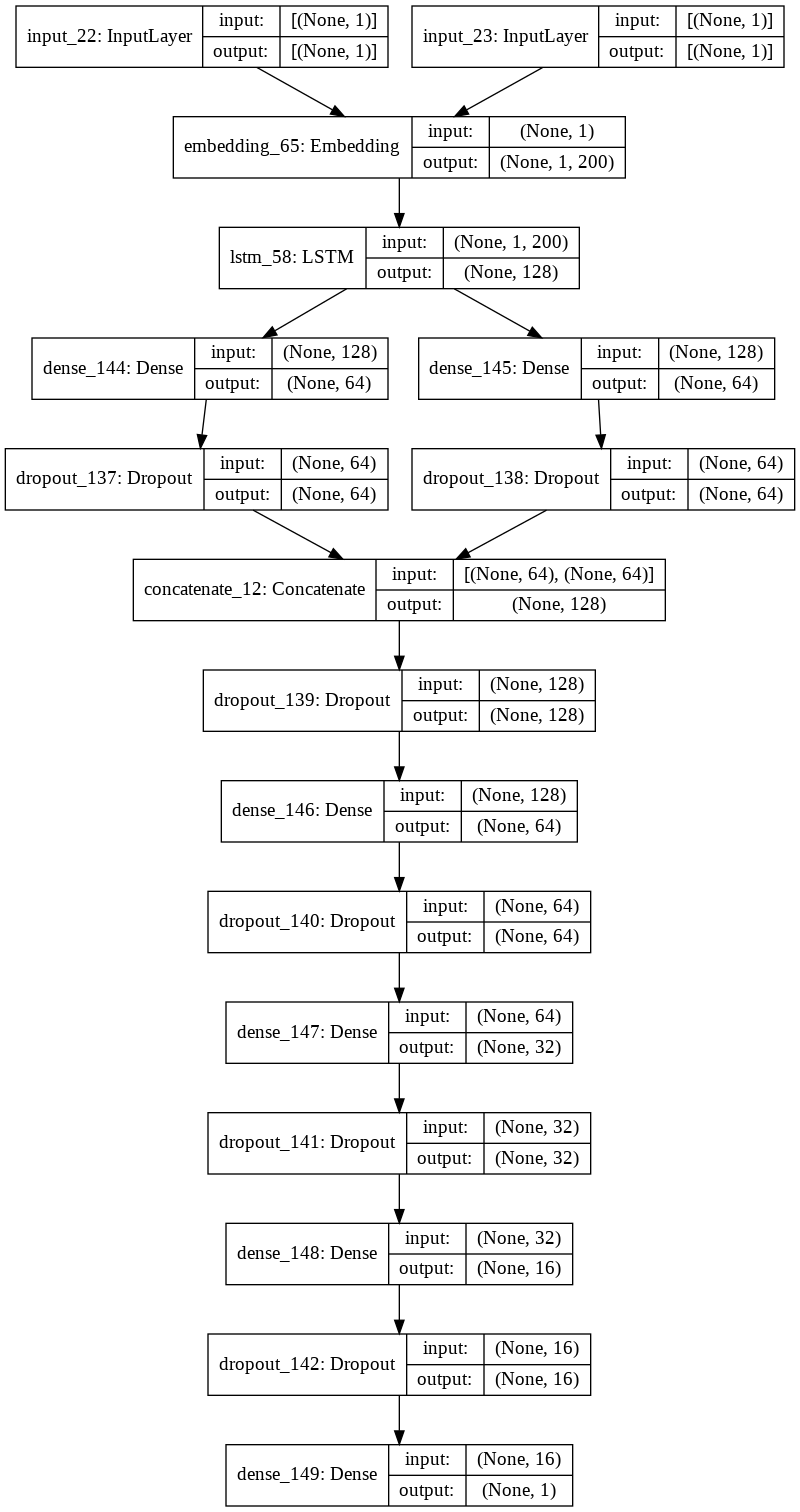

In [522]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [532]:
history = model.fit([X1, X2], Y_train, batch_size=32, epochs=50, verbose=1)


Epoch 1/50
249/249 [==============================] - 4s 17ms/step - loss: 0.6063 - acc: 0.7209
Epoch 2/50
249/249 [==============================] - 4s 17ms/step - loss: 0.6061 - acc: 0.7171
Epoch 3/50
249/249 [==============================] - 4s 15ms/step - loss: 0.6070 - acc: 0.7179
Epoch 4/50
249/249 [==============================] - 4s 16ms/step - loss: 0.6056 - acc: 0.7215
Epoch 5/50
249/249 [==============================] - 4s 15ms/step - loss: 0.6050 - acc: 0.7185
Epoch 6/50
249/249 [==============================] - 4s 16ms/step - loss: 0.6058 - acc: 0.7202
Epoch 7/50
249/249 [==============================] - 4s 17ms/step - loss: 0.6030 - acc: 0.7160
Epoch 8/50
249/249 [==============================] - 4s 15ms/step - loss: 0.6039 - acc: 0.7205
Epoch 9/50
249/249 [==============================] - 4s 15ms/step - loss: 0.6037 - acc: 0.7204
Epoch 10/50
249/249 [==============================] - 4s 15ms/step - loss: 0.6021 - acc: 0.7168
Epoch 11/50
249/249 [==================

In [529]:
X_test = test['Territory']
le = LabelEncoder()
X_test = le.fit_transform(X_test)
X_test = X_test.reshape(-1,1)
X_test.shape

(1567, 1)

In [530]:
X_test2 = test['TRF']
le = LabelEncoder()
X_test2 = le.fit_transform(X_test2)
X_test2 = X_test2.reshape(-1,1)
X_test2.shape

(1567, 1)

In [533]:
MODEL = model.predict([X_test, X_test2])

sub = test[['Opportunity_ID']].copy()
sub['Target'] = MODEL
sub.to_csv("model.csv", index=False)
sub.head(15)


,Opportunity_ID,Target
0,10689,0.655003
3,10690,0.302195
8,10691,0.644558
9,10692,0.296149
15,10693,0.648298
16,10694,0.648298
17,10695,0.643197
20,10696,0.643197
24,10697,0.643197
29,10698,0.643197


In [534]:
 from google.colab import files
 files.download('model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>